In [1]:
from tensorflow.keras.layers import (
    Input,Conv2D,LeakyReLU,Flatten,Dense,Reshape,Conv2DTranspose,Activation,BatchNormalization,
    Dropout,UpSampling2D,MaxPooling2D
)
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
# random weight init
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import plotly.express as px

2023-07-11 21:38:44.579008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
class WGAN:
    def __init__(
        self,
        input_dims,
        critic_conv_filters,
        critic_conv_kernel_size,
        critic_conv_strides,
        critic_batch_norm_momentum,
        critic_activation,
        critic_dropout_rate,
        critic_learning_rate,
        critic_pool_kernel_size,
        critic_optimizer,
        generator_zdim,
        generator_init_dim,
        generator_upsample,
        generator_conv_filters,
        generator_conv_kernel_size,
        generator_conv_strides,
        generator_batch_norm_momentum,
        generator_activation,
        generator_dropout_rate,
        generator_learning_rate,
        generator_optimizer,
    ):
        self.input_dims = input_dims
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate  
        self.critic_learning_rate = critic_learning_rate
        self.critic_pool_kernel_size = critic_pool_kernel_size
        self.critic_optimizer = critic_optimizer
        self.critic_training_loops = 5
        self.generator_zdim = generator_zdim
        self.generator_init_dim = generator_init_dim
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        self.generator_optimizer = generator_optimizer
        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)
        self.weight_init = RandomNormal(mean=0., stddev=0.02)
        self.epoch = 0
        self.d_losses = []
        self.g_losses = []
        self.clip_value = 0.01
        self._build_critic()
        self._build_generator()
        self._build_adversarial()
    def wassserstein(self,y_true,y_pred):
        return -K.mean(y_true*y_pred)
    def _build_critic(self):
        critic_input = Input(shape=self.input_dims,name='critic_input')
        x = critic_input
        for i in range(self.n_layers_critic):
            x = Conv2D(
                filters=self.critic_conv_filters[i],
                kernel_size=self.critic_conv_kernel_size[i],
                strides=self.critic_conv_strides[i],
                padding='same',
                name='critic_conv_'+str(i),
                kernel_initializer=self.weight_init
            )(x)
            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum=self.critic_batch_norm_momentum)(x)
            x = Activation(self.critic_activation)(x)
            if self.critic_pool_kernel_size != None:
                if self.critic_pool_kernel_size[i] != 0:
                    x = MaxPooling2D(pool_size=self.critic_pool_kernel_size[i])(x)
            x = Activation(self.critic_activation)(x)
            if self.critic_dropout_rate:
                x = Dropout(rate=self.critic_dropout_rate)(x)
        x = Flatten()(x)
        critic_output = Dense(1,activation=None,kernel_initializer=self.weight_init)(x)
        self.critic = Model(critic_input,critic_output)
        print('Critic Summary')
        print(self.critic.summary())
    def _build_generator(self):
        generator_input = Input(shape=(self.generator_zdim,),name='generator_input')
        x = generator_input
        x = Dense(np.prod(self.generator_init_dim))(x)
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)
        x = Activation(self.generator_activation)(x)
        x = Reshape(self.generator_init_dim)(x)
        if self.generator_dropout_rate:
            x = Dropout(rate=self.generator_dropout_rate)(x)
        for i in range(self.n_layers_generator):
            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters=self.generator_conv_filters[i],
                    kernel_size=self.generator_conv_kernel_size[i],
                    padding='same',
                    name='generator_conv_'+str(i),
                    kernel_initializer=self.weight_init
                )(x)
            else:
                x = Conv2DTranspose(
                    filters=self.generator_conv_filters[i],
                    kernel_size=self.generator_conv_kernel_size[i],
                    padding='same',
                    strides=self.generator_conv_strides[i],
                    name='generator_conv_'+str(i),
                    kernel_initializer=self.weight_init
                )(x)
            if i < self.n_layers_generator - 1:
                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum=self.generator_batch_norm_momentum)(x)
                x = Activation(self.generator_activation)(x)
            else:
                x = Activation('tanh')(x)
        generator_output = x
        self.generator = Model(generator_input,generator_output)
        print('Generator Summary')
        print(self.generator.summary())
    def _build_adversarial(self):
        self.critic.compile(optimizer=self.critic_optimizer,loss=self.wassserstein)
        self.critic.trainable = False
        model_input = Input(shape=(self.generator_zdim,),name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input,model_output)
        self.generator.compile(optimizer=self.generator_optimizer,loss=self.wassserstein)
        self.model.compile(optimizer=self.generator_optimizer,loss=self.wassserstein)
        self.critic.trainable = True
    
    def train_critic(self,x_train,batch_size):
        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))
        idx = np.random.randint(0,x_train.shape[0],batch_size)
        true_imgs = x_train[idx]
        noise = np.random.normal(0,1,(batch_size,self.generator_zdim))
        gen_imgs = self.generator.predict(noise)
        d_loss_real = self.critic.train_on_batch(true_imgs,valid)
        d_loss_fake = self.critic.train_on_batch(gen_imgs,fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        # 权重剪裁
        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w,-self.clip_value,self.clip_value) for w in weights]
            l.set_weights(weights)
        return d_loss
    def train_generator(self,batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0,1,(batch_size,self.generator_zdim))
        return self.model.train_on_batch(noise,valid)
    def train(self,x_train,batch_size,epochs):
        self.epoch += epochs
        with tqdm(total=epochs,unit=" epoch ") as pbar:
            for epoch in range(epochs):
                for _ in range(self.n_layers_critic):
                    d_loss = self.train_critic(x_train,batch_size)
                g_loss = self.train_generator(batch_size)
                self.d_losses.append(d_loss)
                self.g_losses.append(g_loss)
                pbar.set_description(F"Epoch {epoch}")
                pbar.set_postfix(D_loss=d_loss,G_loss=g_loss)
                pbar.update(1)
    def generate(self,n_samples):
        noise = np.random.uniform(-1,1,size=(n_samples,self.generator_zdim))
        image = self.generator.predict(noise)
        plt.figure(figsize=(10,10))
        for k in range(n_samples):
            plt.subplot(10,10,k + 1)
            plt.imshow(image[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    def plot_losses(self):
        fig = px.line(
            x=np.arange(len(self.d_losses)),
            y=np.array([self.d_losses,self.g_losses]).T,
            labels={'x':'epoch','y':'loss'},
            title='Wasserstein GAN losses'
        )
        fig.update_layout(legend_title_text='loss',title_x=0.5)
        fig.show()

In [24]:
# 加载CIFAR10中汽车的数据集
(x_train,_),(x_test,_) = tf.keras.datasets.cifar10.load_data()
x_train = x_train[np.where(x_train[:,-1] == 1)[0]]

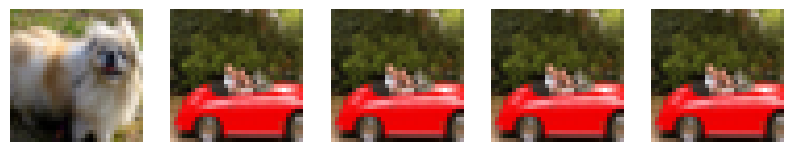

In [25]:
# 显示数据集中的一些图片
plt.figure(figsize=(10,10))
for k in range(5):
    plt.subplot(5,5,k + 1)
    plt.imshow(x_train[k])
    plt.axis('off')

In [54]:
# 实例化模型
gan = WGAN(
        input_dims=(32,32,3),
        critic_conv_filters=[32,64,128,128],   
        critic_conv_kernel_size=[5,5,5,5],
        critic_conv_strides=[1,1,1,1],
        critic_batch_norm_momentum=None,
        critic_activation='leaky_relu',
        critic_dropout_rate=None,
        critic_learning_rate=0.00005,
        critic_optimizer="rmsprop",
        critic_pool_kernel_size= [2,2,2,2],
        generator_init_dim=(4,4,512),
        generator_upsample=[2,2,2],
        generator_conv_filters=[64,32,3],
        generator_conv_kernel_size=[5,5,5],
        generator_conv_strides=[1,1,1,1],
        generator_batch_norm_momentum=0.9,
        generator_activation='leaky_relu',
        generator_dropout_rate=None,
        generator_learning_rate=0.00005,
        generator_optimizer="rmsprop",
        generator_zdim=100,
)


Critic Summary
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      (None, 32, 32, 32)        2432      
                                                                 
 activation_222 (Activation  (None, 32, 32, 32)        0         
 )                                                               
                                                                 
 activation_223 (Activation  (None, 32, 32, 32)        0         
 )                                                               
                                                                 
 critic_conv_1 (Conv2D)      (None, 32, 32, 64)        51264     
                                                                 
 activation_224 (Activation  (None, 32, 32,

/home/elin/anaconda3/envs/tf/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


 generator_conv_0 (Conv2D)   (None, 8, 8, 64)          819264    
                                                                 
 batch_normalization_65 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                               
                                                                 
 activation_231 (Activation  (None, 8, 8, 64)          0         
 )                                                               
                                                                 
 up_sampling2d_27 (UpSampli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 generator_conv_1 (Conv2D)   (None, 16, 16, 32)        51232     
                                                                 
 batch_normalization_66 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
          

In [56]:
# 训练模型
gan.train(x_train=x_train,epochs=1000,batch_size=1)

  0%|          | 0/1000 [00:00<?, ? epoch /s]

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


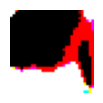

In [57]:
# 生成数据
gan.generate(1)